In [426]:
from fastai.collab import *
from fastai.tabular.all import *
from time import *

In [427]:
path = Path('.')
df = pd.read_csv(path/'training_data.csv', delimiter=',', engine='python',
                     header=0)

In [428]:
df.head()

,date,temp,cloud,rain,wind,humidity,barometer,daily_power
0,2012-01-01,12.583333,overcast clouds,no rain,22.027778,89.000000,1007.611111,5.6
1,2012-01-02,7.432432,scattered clouds,no rain,17.000000,80.027027,1009.864865,2.5
2,2012-01-03,8.894737,overcast clouds,rain,35.131579,78.552632,1006.263158,7.6
3,2012-01-04,7.473684,broken clouds,no rain,26.842105,70.868421,1014.052632,15.1
4,2012-01-05,8.354839,broken clouds,rain,39.935484,75.870968,997.064516,13.1


In [429]:
df['cloud'].unique()

array(['overcast clouds', 'scattered clouds', 'broken clouds',
       'few clouds', 'clear sky'], dtype=object)

/home/nhat/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


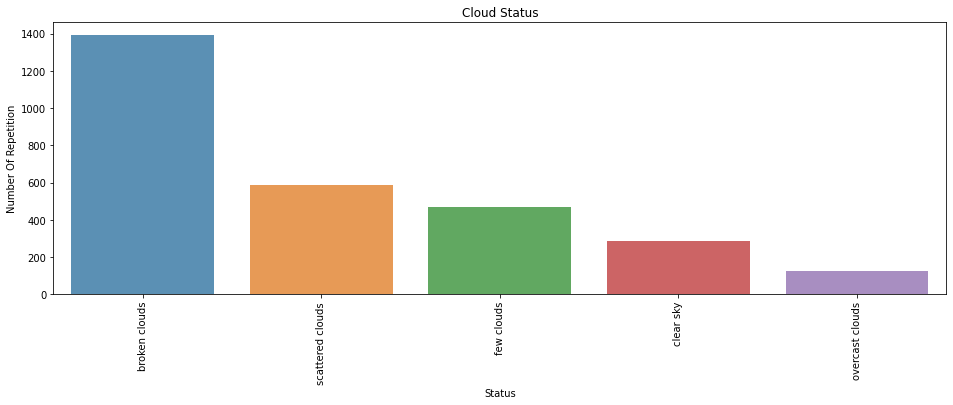

In [430]:
import seaborn as sns
weather_counts = df['cloud'].value_counts()
plt.figure(figsize=(16,5))
sns.barplot(weather_counts.index, weather_counts.values, alpha=0.8)
plt.xticks(rotation=90)
plt.title('Cloud Status')
plt.xlabel('Status')
plt.ylabel('Number Of Repetition')
plt.show()

In [431]:
df['rain'].unique()

array(['no rain', 'rain', 'drizzle', 'snow', 'thunderstorms'],
      dtype=object)

'rain' can be seen as pure caregorical data since they cannot be put into a suitable ordering. However, 'cloud' in this case is ordinal columns. According to the document of OpenWeather API, the order is as follow:

In [432]:
cloud_levels = 'overcast clouds', 'broken clouds', 'scattered clouds', 'few clouds', 'clear sky'
#cloud_levels = 'Overcast', 'Cloudy', 'Mostly cloudy', 'Haze', 'Ice Fog', 'Fog', 'Broken clouds', 'More clouds than sun', 'Passing clouds', 'Scattered clouds', 'Low clouds', 'Partly sunny', 'Clear', 'Sunny'

In [433]:
df.isna().sum()

date           0
temp           0
cloud          0
rain           0
wind           0
humidity       0
barometer      0
daily_power    0
dtype: int64

In [434]:
df['cloud'] = df['cloud'].astype('category')
df['cloud'].cat.set_categories(cloud_levels, ordered=True, inplace=True)

Date is useless in predicting the energy production, so we can drop it out

In [435]:
df.drop(labels='date', axis=1, inplace=True)
df.head()

,temp,cloud,rain,wind,humidity,barometer,daily_power
0,12.583333,overcast clouds,no rain,22.027778,89.000000,1007.611111,5.6
1,7.432432,scattered clouds,no rain,17.000000,80.027027,1009.864865,2.5
2,8.894737,overcast clouds,rain,35.131579,78.552632,1006.263158,7.6
3,7.473684,broken clouds,no rain,26.842105,70.868421,1014.052632,15.1
4,8.354839,broken clouds,rain,39.935484,75.870968,997.064516,13.1


fastai determines which columns should be treated as categorical variables by comparing the number of distinct levels in the variable to the value of the max_card variable:

In [436]:
df.drop(labels=['cloud', 'rain'], axis=1, inplace=True)
cont_df,cat_df = cont_cat_split(df, max_card = 15, dep_var = 'daily_power')

In [437]:
df[cat_df].nunique()

Series([], dtype: float64)

The data must be normalized before being fed to the neural network:

In [438]:
procs_nn = [Categorify, Normalize]
splits = RandomSplitter(0.2)(range_of(df))
to_nn = TabularPandas(df, procs_nn, cat_df, cont_df, splits=splits, y_names='daily_power')

In [439]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2864 entries, 0 to 2863
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temp         2864 non-null   float64
 1   wind         2864 non-null   float64
 2   humidity     2864 non-null   float64
 3   barometer    2864 non-null   float64
 4   daily_power  2864 non-null   float64
dtypes: float64(5)
memory usage: 112.0 KB


In [440]:
dls = to_nn.dataloaders(1024)

In [441]:
y = to_nn.train.y
y.min(), y.max()

(0.02, 34.0)

In [442]:
from fastai.tabular.all import*

In [448]:
learn = tabular_learner(dls, y_range=(-0.2, 34.5), n_out=1, loss_func=F.mse_loss)

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=0.0008317637839354575)

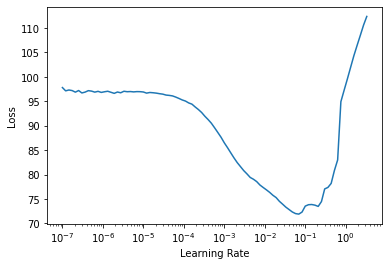

In [449]:
learn.lr_find()

In [450]:
learn.fine_tune(20, 6e-2)

epoch,train_loss,valid_loss,time
0,79.841553,49.064896,00:00


epoch,train_loss,valid_loss,time
0,90.304810,48.935535,00:00
1,75.343765,61.525597,00:00
2,69.880661,52.950310,00:00
3,64.931000,57.707783,00:00
4,61.938080,60.019749,00:00
5,60.557381,55.403652,00:00
6,59.521801,63.532425,00:00
7,58.986835,51.825439,00:00
8,58.246941,53.167713,00:00
9,57.409378,55.152058,00:00


In [451]:
preds,targs = learn.get_preds()

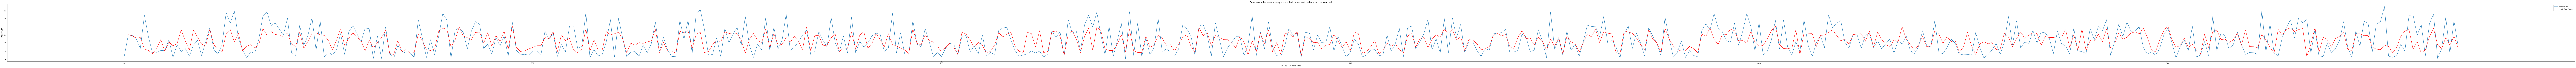

In [452]:
plt.figure(figsize=(260,6))
plt.plot(range(len(targs)), targs)
plt.plot(range(len(preds)), preds, 'r')
plt.title('Comparison between average predicted values and real ones in the valid set')
plt.ylabel('Day Power')
plt.xlabel('Average Of Valid Data')
plt.legend(['Real Power', 'Predicted Power'])
plt.show()